In [31]:
import nibabel as nib
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import ipywidgets as widgets
from ipywidgets import interact

In [163]:
import scipy.ndimage

## User Input

Setup Input Variables and Data locations

In [13]:
input_folder='../dataset/images' 
labels_foler = '../dataset/labels'
output_folder ='../dataset/output' 

ct_prefix = '__CT.nii.gz'
pet_prefix = '__PT.nii.gz'



## Load Image

In [ ]:
try:
    subdir, dirs, files = os.walk(input_folder).next()
    files = [k for k in files if ct_prefix in k]
except:
    subdir, dirs, files = os.walk(input_folder).__next__()
    files = [k for k in files if ct_prefix in k]

In [215]:
# Function to visualize CT data interactively
def show_ct_data(ct_data):
    # Ensure ct_data is a NumPy array
    ct_data = np.asarray(ct_data)
    
    # Define the function to plot a specific slice
    def plot_slice(slice_idx):
        plt.figure(figsize=(6, 6))
        plt.imshow(ct_data[:, :, slice_idx], cmap='gray')
        plt.title(f"Slice {slice_idx}")
        # plt.axis('off')
        plt.show()
    
    # Create an interactive slider to select slices
    interact(plot_slice, slice_idx=widgets.IntSlider(min=0, max=ct_data.shape[2] - 1, step=1, value=0))

In [107]:
# Function to visualize CT data with label contours interactively
def show_ct_data_with_labels(ct_data, label_data):
    """
    Display CT image slices with overlaid label contours interactively.

    Parameters:
    - ct_data: NumPy array of CT image data with shape (height, width, slices).
    - label_data: NumPy array of label data with the same shape as ct_data.
    """
    # Ensure ct_data and label_data are NumPy arrays
    ct_data = np.asarray(ct_data)
    label_data = np.asarray(label_data)
    
    # Verify that the shapes match
    if ct_data.shape != label_data.shape:
        raise ValueError("CT data and label data must have the same shape.")
    
    # Define the function to plot a specific slice
    def plot_slice(slice_idx):
        plt.figure(figsize=(6, 6))
        plt.imshow(ct_data[:, :, slice_idx], cmap='gray')
        
        # Overlay the label as a contour
        contours = plt.contour(label_data[:, :, slice_idx], levels=np.unique(label_data), colors='r', linewidths=0.5)
        
        # Optionally, add a colorbar or legend for labels
        # plt.clabel(contours, inline=True, fontsize=8)
        
        plt.title(f"Slice {slice_idx}")
        plt.axis('off')
        plt.show()
    
    # Create an interactive slider to select slices
    interact(plot_slice, slice_idx=widgets.IntSlider(min=0, max=ct_data.shape[2] - 1, step=1, value=0))

In [50]:
def apply_window(img, width=500, center=40, normal=True):
    img = np.asarray(img)
    # convert below window to black
    img[img<(center-(width/2))]=center-(width/2)
    # convert above window to white
    img[img>(center+(width/2))]=center+(width/2)

    if normal:
        # normalize image
        img_scaled = (img - np.min(img)) / (np.max(img) - np.min(img))
        # print(img_scaled.shape)
        # print(np.min(img_scaled), np.max(img_scaled))
        return img_scaled
    else:
        return img

In [52]:
# Function to normalize CT data to values between 0 and 1
def normalize_img(img):
    img = np.asarray(img)
    return (img - np.min(img)) / (np.max(img) - np.min(img))

In [98]:
def normalize_0_1(image):
    """
    Normalize the input image to have pixel values between 0 and 1.

    Parameters:
    - image: NumPy array representing the image. Can be 2D (grayscale) or 3D (color).

    Returns:
    - normalized_image: NumPy array with pixel values normalized between 0 and 1.
    """
    # Convert the image to float32 if it's not already
    image = image.astype('float32')

    # Find the minimum and maximum pixel values
    min_val = np.min(image)
    max_val = np.max(image)

    # Avoid division by zero
    if max_val > min_val:
        normalized_image = (image - min_val) / (max_val - min_val)
    else:
        # Image has constant value; return an array of zeros
        normalized_image = np.zeros_like(image)

    return normalized_image




def normalize_0_1_global(image):
    """
    Normalize each channel of the input image to have pixel values between 0 and 1,
    independently for each channel.

    Parameters:
    - image: NumPy array of shape (height, width, channels)

    Returns:
    - normalized_image: NumPy array with pixel values normalized between 0 and 1 in each channel.
    """
    # Convert the image to float32 if it's not already
    image = image.astype('float32')
    
    # Initialize the output array
    normalized_image = np.zeros_like(image)
    
    # Normalize each channel independently
    for c in range(image.shape[2]):
        channel = image[:, :, c]
        min_val = np.min(channel)
        max_val = np.max(channel)
        
        if max_val > min_val:
            normalized_image[:, :, c] = (channel - min_val) / (max_val - min_val)
        else:
            # Channel has constant value; set to zeros
            normalized_image[:, :, c] = np.zeros_like(channel)
    
    return normalized_image




In [17]:
# prepare image names
ct_image_name = files[0]
pt_image_name = files[0].split('__')[0]+pet_prefix
label_name = files[0].split('__')[0]+'.nii.gz'

print(ct_image_name)
print(pt_image_name)
print(label_name)





MDA-079__CT.nii.gz
MDA-079__PT.nii.gz
MDA-079.nii.gz


### Process CT Images 

In [166]:
# process CT image
ct = nib.load(os.path.join(input_folder, ct_image_name))
ct_data = ct.get_fdata().astype(np.float32)
# apply CT windowing and normalize image
ct_data_window = apply_window(ct_data)

segdata = np.ones(np.shape(ct_data_window))

# Z-interpolation
data_r = np.rot90(ct_data_window, axes=(0,2))
segdata_r = np.rot90(segdata, axes=(0,2))
Scn = segdata.shape[0]
factor = 3

#now loop through slices
dataslc = np.zeros(shape=[segdata.shape[2]*factor,Scn])
img_stack_r = np.zeros(shape=[segdata.shape[2]*factor,Scn,Scn])
seg_stack_r = np.zeros(shape=[segdata.shape[2]*factor,Scn,Scn])

for io in range(0,np.shape(segdata_r)[2]):
    dataslc = cv2.resize(data_r[:,:,io], (Scn, segdata.shape[2]*factor), interpolation=cv2.INTER_CUBIC)
    img_stack_r[:,:,io] = dataslc
    dataslc = cv2.resize(segdata_r[:,:,io], (Scn, segdata.shape[2]*factor), interpolation=cv2.INTER_NEAREST)
    seg_stack_r[:,:,io] = dataslc

img_stack = np.rot90(img_stack_r, 3, axes=(0,2))
print(np.shape(img_stack))
seg_stack = np.rot90(seg_stack_r, 3, axes=(0,2))

img_stack = normalize_0_1_global(img_stack)

(512, 512, 381)


In [101]:
show_ct_data(img_stack)


interactive(children=(IntSlider(value=0, description='slice_idx', max=380), Output()), _dom_classes=('widget-i…

In [71]:
img_stack.shape

(512, 512, 381)

Min pixel value: 0.0
Max pixel value: 1.0


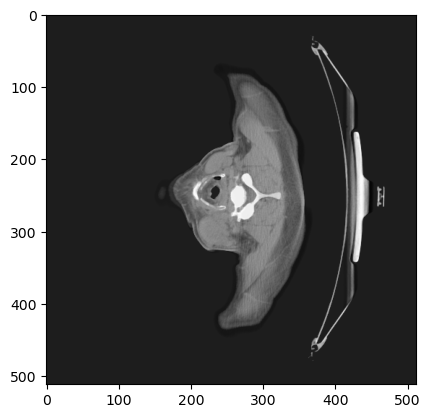

In [103]:
n=119
plt.imshow(img_stack[:,:,n], cmap='gray')
# Verify the normalization
print('Min pixel value:', img_stack[:,:,n].min())
print('Max pixel value:', img_stack[:,:,n].max())

### Process Label

In [122]:
# process Label
label = nib.load(os.path.join(labels_foler, label_name))
label_data = label.get_fdata().astype(np.float32)

#show_ct_data(label_data)

segdata = np.ones(np.shape(label_data))

# # Z-interpolation
label_data_r = np.rot90(label_data, axes=(0,2))
segdata_r = np.rot90(segdata, axes=(0,2))
Scn = segdata.shape[0]
factor = 3

# show_ct_data(label_data_r)

#now loop through slices
dataslc = np.zeros(shape=[segdata.shape[2]*factor,Scn])
label_stack_r = np.zeros(shape=[segdata.shape[2]*factor,Scn,Scn])
seg_stack_r = np.zeros(shape=[segdata.shape[2]*factor,Scn,Scn])

# show_ct_data(label_stack_r)

for io in range(0,np.shape(segdata_r)[2]):
    dataslc = cv2.resize(label_data_r[:,:,io], (Scn, segdata.shape[2]*factor), interpolation=cv2.INTER_NEAREST)
    label_stack_r[:,:,io] = dataslc
    dataslc = cv2.resize(segdata_r[:,:,io], (Scn, segdata.shape[2]*factor), interpolation=cv2.INTER_NEAREST)
    seg_stack_r[:,:,io] = dataslc

# show_ct_data(label_stack_r)

label_stack = np.rot90(label_stack_r, 3, axes=(0,2))
print(np.shape(label_stack))
seg_stack = np.rot90(seg_stack_r, 3, axes=(0,2))

show_ct_data(label_stack)

(512, 512, 381)


interactive(children=(IntSlider(value=0, description='slice_idx', max=380), Output()), _dom_classes=('widget-i…

In [123]:
show_ct_data_with_labels(img_stack, label_stack)

interactive(children=(IntSlider(value=0, description='slice_idx', max=380), Output()), _dom_classes=('widget-i…

### Process Pet Image

In [ ]:
# process PET image
pt = nib.load(os.path.join(input_folder, pt_image_name))
pt_data = pt.get_fdata().astype(np.float32)

segdata = np.ones(np.shape(pt_data))

# Z-interpolation
data_r = np.rot90(pt_data, axes=(0,2))
segdata_r = np.rot90(segdata, axes=(0,2))
Scn = segdata.shape[0]
factor = 3

#now loop through slices
dataslc = np.zeros(shape=[segdata.shape[2]*factor,Scn])
pet_stack_r = np.zeros(shape=[segdata.shape[2]*factor,Scn,Scn])
seg_stack_r = np.zeros(shape=[segdata.shape[2]*factor,Scn,Scn])

# show_ct_data(data_r)

for io in range(0,np.shape(segdata_r)[2]):
    dataslc = cv2.resize(data_r[:,:,io], (Scn, segdata.shape[2]*factor), interpolation=cv2.INTER_CUBIC)
    pet_stack_r[:,:,io] = dataslc
    dataslc = cv2.resize(segdata_r[:,:,io], (Scn, segdata.shape[2]*factor), interpolation=cv2.INTER_NEAREST)
    seg_stack_r[:,:,io] = dataslc

pet_stack = np.rot90(pet_stack_r, 3, axes=(0,2))
print(np.shape(pet_stack))
seg_stack = np.rot90(seg_stack_r, 3, axes=(0,2))


show_ct_data(pet_stack)
# img_stack = normalize_0_1_global(img_stack)

(128, 128, 381)


interactive(children=(IntSlider(value=0, description='slice_idx', max=380), Output()), _dom_classes=('widget-i…

In [168]:



# Define the target shape
target_shape = img_stack.shape

print('pet shape: ', pet_stack.shape)
print('target shape: ', target_shape)


# Calculate the scaling factors for each dimension
scaling_factors = (
    target_shape[0] / pt_data.shape[0],  # Scaling factor for height
    target_shape[1] / pt_data.shape[1],  # Scaling factor for width
    target_shape[2] / pt_data.shape[2]   # Scaling factor for depth
)

# Use scipy.ndimage.zoom to resize the image stack
# Order = 3 indicates cubic interpolation, which is suitable for smooth transitions
resized_pet_data = scipy.ndimage.zoom(pt_data, scaling_factors, order=3)

# Check the shape of the resized data
print("Original shape:", pt_data.shape)
print("Resized shape:", resized_pet_data.shape)


pet shape:  (128, 128, 381)
target shape:  (512, 512, 381)
Original shape: (128, 128, 127)
Resized shape: (512, 512, 381)


In [169]:
show_ct_data_with_labels(resized_pet_data, label_stack)

interactive(children=(IntSlider(value=0, description='slice_idx', max=380), Output()), _dom_classes=('widget-i…

## Upsample Pet image

In [200]:
import nibabel as nib
import numpy as np
import scipy.ndimage
from skimage.transform import resize


In [190]:
# Function to visualize CT data interactively
def show_res_image(ct_data):
    # Ensure ct_data is a NumPy array
    ct_data = np.asarray(ct_data)
    
    # Define the function to plot a specific slice
    def plot_slice(slice_idx):
        plt.figure(figsize=(6, 6))
        plt.imshow(ct_data[:, :, slice_idx], cmap='gray')
        plt.title(f"Slice {slice_idx}")
        # plt.axis('off')
        plt.show()
    
    # Create an interactive slider to select slices
    interact(plot_slice, slice_idx=widgets.IntSlider(min=0, max=127, step=1, value=0))

In [201]:

def resample_and_align_pet_to_ct(pet_image_path, ct_image_path, output_path=''):
    # Load the PET and CT images
    pet_img = nib.load(pet_image_path)  # Load PET NIfTI image
    ct_img = nib.load(ct_image_path)    # Load CT NIfTI image

    # Extract data and affine from the PET image
    pet_data = pet_img.get_fdata()      # Get PET voxel data (128, 128, 127)
    pet_affine = pet_img.affine         # Get PET affine transformation matrix

    # Extract data and affine from the CT image
    ct_data = ct_img.get_fdata()        # Get CT voxel data (512, 512, 127)
    ct_affine = ct_img.affine           # Get CT affine transformation matrix

    # Compute scaling factors to match PET to CT resolution (512, 512, 127)
    pet_voxel_size = pet_img.header.get_zooms()[:3]   # PET voxel size (5.46875, 5.46875, 3.27)
    ct_voxel_size = ct_img.header.get_zooms()[:3]     # CT voxel size (0.976562, 0.976562, 3.27)
    
    scaling_factors = (
        pet_voxel_size[0] / ct_voxel_size[0],  # Scaling factor for X
        pet_voxel_size[1] / ct_voxel_size[1],  # Scaling factor for Y
        pet_voxel_size[2] / ct_voxel_size[2]   # Scaling factor for Z
    )

    # Resample the PET image using scipy.ndimage.zoom to match CT dimensions
    pet_resampled_data = scipy.ndimage.zoom(pet_data, scaling_factors, order=3)  # Cubic interpolation

    # Now explicitly resize to the exact CT dimensions using skimage.transform.resize
    target_shape = ct_data.shape
    pet_resampled_data = resize(
        pet_resampled_data,
        target_shape,
        mode='reflect',
        anti_aliasing=True,
        order=3  # Cubic interpolation
    )

    # Compute the new affine transformation matrix for the resampled PET
    pet_new_affine = np.copy(ct_affine)  # Start with the CT affine transformation matrix

    # Adjust the qoffset (origin) to match CT image origin
    pet_new_affine[:3, 3] = ct_affine[:3, 3]

    # Create a new NIfTI image with the resampled PET data and new affine matrix
    pet_resampled_img = nib.Nifti1Image(pet_resampled_data, pet_new_affine)

    # Save the resampled PET image to the output path
    # nib.save(pet_resampled_img, output_path)
    return pet_resampled_img


In [202]:

ct_path = os.path.join(input_folder, ct_image_name)
pt_path = os.path.join(input_folder, pt_image_name)

# Example usage
res_pet = resample_and_align_pet_to_ct(pt_path, ct_path)
res_pet_data = res_pet.get_fdata()
res_pet_data.shape

(512, 512, 127)

In [203]:
show_res_image(res_pet_data)

interactive(children=(IntSlider(value=0, description='slice_idx', max=127), Output()), _dom_classes=('widget-i…

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

In [216]:
# process CT image
# ct = nib.load(os.path.join(input_folder, ct_image_name))
# ct_data = ct.get_fdata().astype(np.float32)
# # apply CT windowing and normalize image
# ct_data_window = apply_window(ct_data)

segdata = np.ones(np.shape(res_pet_data))

# Z-interpolation
pet_data_r = np.rot90(res_pet_data, axes=(0,2))
segdata_r = np.rot90(segdata, axes=(0,2))
Scn = segdata.shape[0]
factor = 3

show_ct_data(pet_data_r)

#now loop through slices
dataslc = np.zeros(shape=[segdata.shape[2]*factor,Scn])
pet_stack_r = np.zeros(shape=[segdata.shape[2]*factor,Scn,Scn])
seg_stack_r = np.zeros(shape=[segdata.shape[2]*factor,Scn,Scn])

for io in range(0,np.shape(segdata_r)[2]):
    dataslc = cv2.resize(pet_data_r[:,:,io], (Scn, segdata.shape[2]*factor), interpolation=cv2.INTER_CUBIC)
    pet_stack_r[:,:,io] = dataslc
    dataslc = cv2.resize(segdata_r[:,:,io], (Scn, segdata.shape[2]*factor), interpolation=cv2.INTER_NEAREST)
    seg_stack_r[:,:,io] = dataslc

show_ct_data(pet_stack_r)

pet_stack = np.rot90(pet_stack_r, 3, axes=(0,2))
print(np.shape(pet_stack))
# seg_stack = np.rot90(seg_stack_r, 3, axes=(0,2))
show_ct_data(pet_stack)
# img_stack = normalize_0_1_global(img_stack)

interactive(children=(IntSlider(value=0, description='slice_idx', max=511), Output()), _dom_classes=('widget-i…

interactive(children=(IntSlider(value=0, description='slice_idx', max=511), Output()), _dom_classes=('widget-i…

(512, 512, 381)


interactive(children=(IntSlider(value=0, description='slice_idx', max=380), Output()), _dom_classes=('widget-i…

In [217]:
show_ct_data_with_labels(pet_stack, label_stack)

interactive(children=(IntSlider(value=0, description='slice_idx', max=380), Output()), _dom_classes=('widget-i…

In [181]:
print(ct.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 512 512 127   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1.       0.976562 0.976562 3.27     0.       0.       0.       0.      ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 1.0
qoffset_x       : 250.0
qoffset_y       : 250.0
qoffset_z       : -444.5

# Sandbox

In [14]:
os.listdir(labels_foler)

['MDA-117.nii.gz', 'CHUM-001.nii.gz', 'MDA-079.nii.gz', 'CHUM-002.nii.gz']

In [7]:
try:
    subdir, dirs, files = os.walk(input_folder).next()
    files = [k for k in files if ct_prefix in k]
except:
    subdir, dirs, files = os.walk(input_folder).__next__()
    files = [k for k in files if ct_prefix in k]

files

['MDA-079__CT.nii.gz',
 'CHUM-002__CT.nii.gz',
 'CHUM-001__CT.nii.gz',
 'MDA-117__CT.nii.gz']

In [ ]:
# pt = nib.load(os.path.join(input_folder, pt_image_name))
# pt_data = pt.get_fdata().astype(np.float32)

# lbl = nib.load(os.path.join(labels_foler, label_name))
# lbl_data = lbl.get_fdata().astype(np.float32)

# print(pt_data.shape)
# print(lbl_data.shape)

In [170]:
print(pt.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 128 128 127   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1.      5.46875 5.46875 3.27    0.      0.      0.      0.     ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 1.0
qoffset_x       : 347.26562
qoffset_y       : 347.26562
qoffset_z       : -444.5

In [171]:
print(ct.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 512 512 127   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1.       0.976562 0.976562 3.27     0.       0.       0.       0.      ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 1.0
qoffset_x       : 250.0
qoffset_y       : 250.0
qoffset_z       : -444.5